# **VINTAGE ANALYSIS**

The data consists of monthly snapshots taken when each report was generated. Since there's no information about the initial appearance month of each individual ID, the standard vintage analysis approach is not applicable. Worked around, I calculate the cumulative sum of 'bad'-labeled observations for each month. While this method doesn't allow for analysis across different obs horizons, it still provides insight into the overall trend of the cumulative bad rate over time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils.utils as utils

# !pip freeze > ../requirements.txt

In [88]:
data = pd.read_csv(f'..\data\data_vintage.csv')

In [89]:
# Ordering the STATUS by DPD:
status_order = ['C', 'X', 'DPD0', 'DPD1-30', 'DPD31-60', 'DPD61-90', 'DPD91-120', 'DPD120+']
data['STATUS'] = pd.Categorical(data['STATUS'], categories=status_order, ordered=True)
data = data.sort_values(['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=True)

In [95]:
def _flag_bad(data, threshold='DPD61-90', start_mths=1):
    threshold = threshold
    mask = data[data['STATUS'] >= threshold]
    first_mask = mask.loc[mask.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmin()]
    data = data.merge(first_mask, on='SK_ID_BUREAU', suffixes=('', '_FIRST'), how='left')
    data['FLAG_BAD'] = (data['MONTHS_BALANCE'] >= data['MONTHS_BALANCE_FIRST']).astype(int)
    data = data.drop(['MONTHS_BALANCE_FIRST', 'STATUS_FIRST'], axis = 1)
    data = data[data['MONTHS_BALANCE'] > start_mths]
    data['MOB'] = data['MONTHS_BALANCE'] - start_mths
    data['CUMSUM_BAD'] = data.groupby('MOB')['FLAG_BAD'].transform('sum')
    return(data)
def _vintage(data, threshold='DPD61-90', start_mths=1):
    data = _flag_bad(data, threshold=threshold, start_mths=start_mths)
    vintage = data['MOB'].unique()
    vintage = pd.DataFrame(vintage, columns=['MOB'])
    vintage = vintage.merge(data.groupby('MOB')['CUMSUM_BAD'].mean().reset_index(), on='MOB', how='left')
    vintage['%CUMSUM_BAD'] = vintage['CUMSUM_BAD'] / vintage['CUMSUM_BAD'].max()
    plt.figure(figsize=(6, 6))
    sns.lineplot(x='MOB', y='%CUMSUM_BAD', data=vintage, markers='o')
    plt.xlabel('MOB')
    plt.ylabel('%CUMSUM_BAD')
    return vintage, plt

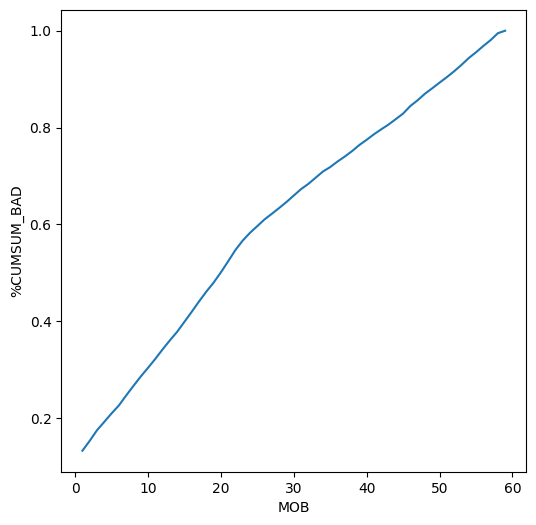

In [98]:
dpd30, plt_dpd30 = _vintage(data, threshold='DPD31-60', start_mths=1)

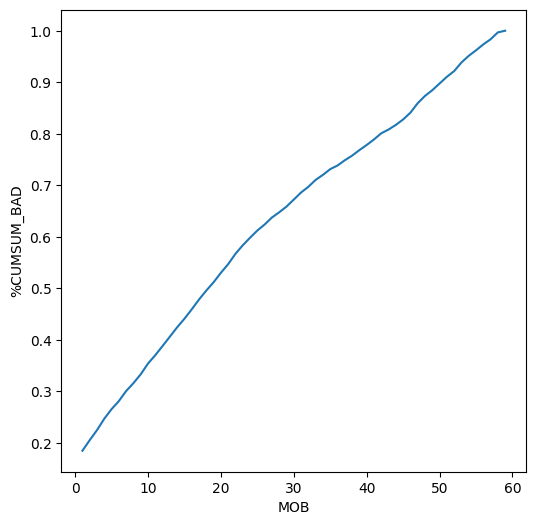

In [ ]:
dpd60, plt_dpd60 = _vintage(data, threshold='DPD61-90', start_mths=1)

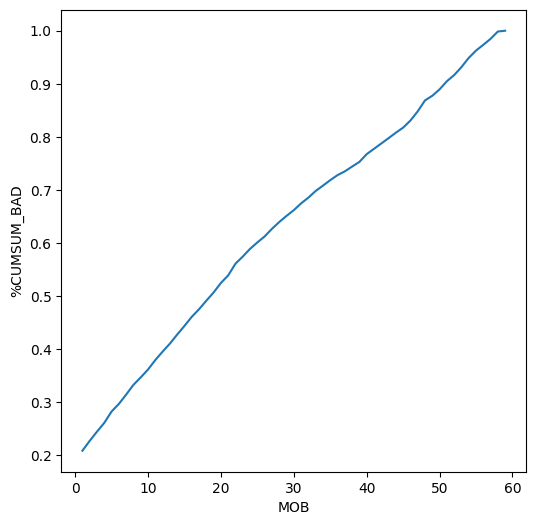

In [99]:
dpd90, plt_dpd90 = _vintage(data, threshold='DPD91-120', start_mths=1)